In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, auc
from eli5.sklearn import PermutationImportance
from eli5.lightgbm import explain_weights_lightgbm
from xgboost import XGBClassifier
from collections import defaultdict
import shap
import eli5
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#the data used in this excercise was sourced from http://www.football-data.co.uk
df = pd.read_csv('2000_2019.csv')
df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,Date,Div,FTAG,...,HTR,HY,HomeTeam,IWA,IWD,IWH,Referee,WHA,WHD,WHH
0,6.0,12.0,0.0,8.0,4.0,2.0,Man City,19/08/00,E0,0.0,...,H,1.0,Charlton,2.7,2.9,2.20,Rob Harris,3.10,3.2,2.10
1,7.0,14.0,0.0,12.0,5.0,2.0,West Ham,19/08/00,E0,2.0,...,H,1.0,Chelsea,4.2,3.2,1.60,Graham Barber,6.50,3.6,1.44
2,4.0,21.0,0.0,16.0,9.0,3.0,Middlesbrough,19/08/00,E0,3.0,...,D,5.0,Coventry,2.7,2.9,2.20,Barry Knight,2.62,3.2,2.30
3,8.0,13.0,0.0,13.0,6.0,1.0,Southampton,19/08/00,E0,2.0,...,A,1.0,Derby,3.5,3.0,1.80,Andy D'Urso,3.20,3.2,2.00
4,4.0,20.0,0.0,12.0,6.0,3.0,Everton,19/08/00,E0,0.0,...,H,1.0,Leeds,4.5,3.3,1.55,Dermot Gallagher,4.50,3.5,1.61


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7220 entries, 0 to 7219
Data columns (total 29 columns):
AC          7220 non-null float64
AF          7220 non-null float64
AR          7220 non-null float64
AS          7220 non-null float64
AST         7220 non-null float64
AY          7220 non-null float64
AwayTeam    7220 non-null object
Date        7220 non-null object
Div         7220 non-null object
FTAG        7220 non-null float64
FTHG        7220 non-null float64
FTR         7220 non-null object
HC          7220 non-null float64
HF          7220 non-null float64
HR          7220 non-null float64
HS          7220 non-null float64
HST         7220 non-null float64
HTAG        7220 non-null float64
HTHG        7220 non-null float64
HTR         7220 non-null object
HY          7220 non-null float64
HomeTeam    7220 non-null object
IWA         7220 non-null float64
IWD         7220 non-null float64
IWH         7220 non-null float64
Referee     7220 non-null object
WHA         7220

In [3]:
# Lets calculate the win % of the three outcomes from the matches.
res = dict(df.FTR.value_counts())
print('Home Team: {}%'.format(round(res['H']/(sum(res.values())), 2)),
     '\nAway Team: {}%'.format(round(res['A']/(sum(res.values())), 2)),
     '\nDraw: {}%'.format(round(res['D']/(sum(res.values())), 2)))

Home Team: 0.46% 
Away Team: 0.28% 
Draw: 0.25%


<h3>Over the past two EPL seasons, the home team has won 46% of matches. This will mark our baseline, if we picked home team to win every game we would be correct 46% of the time based of this data.</h3>

In [4]:
df.loc[df['FTR'] == 'H'].describe()

,AC,AF,AR,AS,AST,AY,FTAG,FTHG,HC,HF,...,HST,HTAG,HTHG,HY,IWA,IWD,IWH,WHA,WHD,WHH
count,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,...,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000
mean,4.708668,12.043491,0.120048,9.577897,4.137623,1.755734,0.535001,2.416443,6.212988,11.256181,...,7.378612,0.242478,1.078642,1.226095,5.131777,3.782067,2.015622,5.692617,3.819026,2.079448
std,2.745083,3.981320,0.342909,4.183260,2.567818,1.266806,0.699297,1.191424,3.045675,3.823337,...,3.340963,0.478570,0.911658,1.143124,3.364545,0.995833,0.905875,4.135876,1.083139,1.065661
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.200000,2.500000,1.050000,1.180000,2.800000,1.050000
25%,3.000000,9.000000,0.000000,7.000000,2.000000,1.000000,0.000000,2.000000,4.000000,9.000000,...,5.000000,0.000000,0.000000,0.000000,2.900000,3.200000,1.450000,3.000000,3.200000,1.440000
50%,4.000000,12.000000,0.000000,9.000000,4.000000,2.000000,0.000000,2.000000,6.000000,11.000000,...,7.000000,0.000000,1.000000,1.000000,3.900000,3.400000,1.800000,4.200000,3.400000,1.830000
75%,6.000000,14.000000,0.000000,12.000000,6.000000,3.000000,1.000000,3.000000,8.000000,14.000000,...,9.000000,0.000000,2.000000,2.000000,6.500000,4.000000,2.250000,7.500000,4.000000,2.300000
max,17.000000,28.000000,2.000000,27.000000,20.000000,7.000000,4.000000,9.000000,19.000000,26.000000,...,24.000000,3.000000,5.000000,7.000000,29.000000,12.000000,13.000000,46.000000,13.000000,17.000000


In [5]:
df.loc[df['FTR'] == 'A'].describe()

,AC,AF,AR,AS,AST,AY,FTAG,FTHG,HC,HF,...,HST,HTAG,HTHG,HY,IWA,IWD,IWH,WHA,WHD,WHH
count,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,...,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000
mean,4.923567,11.792749,0.054385,12.140127,6.187653,1.658991,2.268496,0.563939,5.881921,11.634983,...,5.077413,0.975502,0.254777,1.586477,2.870984,3.467187,3.272375,3.028831,3.491744,3.510722
std,2.676521,4.038014,0.231113,4.517066,2.852856,1.233252,1.071664,0.696597,3.047704,3.779917,...,3.064004,0.863978,0.490856,1.219729,1.599953,0.598037,1.914315,1.972310,0.611083,2.250036
min,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.120000,2.600000,1.150000,1.120000,2.800000,1.120000
25%,3.000000,9.000000,0.000000,9.000000,4.000000,1.000000,1.000000,0.000000,4.000000,9.000000,...,3.000000,0.000000,0.000000,1.000000,1.800000,3.100000,2.050000,1.750000,3.200000,2.100000
50%,5.000000,11.000000,0.000000,12.000000,6.000000,2.000000,2.000000,0.000000,6.000000,11.000000,...,5.000000,1.000000,0.000000,1.000000,2.600000,3.300000,2.500000,2.620000,3.300000,2.600000
75%,7.000000,14.000000,0.000000,15.000000,8.000000,2.000000,3.000000,1.000000,8.000000,14.000000,...,7.000000,1.000000,0.000000,2.000000,3.300000,3.600000,4.100000,3.500000,3.600000,4.500000
max,17.000000,29.000000,2.000000,30.000000,20.000000,8.000000,7.000000,4.000000,19.000000,28.000000,...,21.000000,5.000000,3.000000,6.000000,18.000000,9.000000,20.000000,23.000000,9.000000,21.000000


In [6]:
df.loc[df['FTR'] == 'D'].describe()

,AC,AF,AR,AS,AST,AY,FTAG,FTHG,HC,HF,...,HST,HTAG,HTHG,HY,IWA,IWD,IWH,WHA,WHD,WHH
count,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,...,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000
mean,4.750823,12.380351,0.086718,10.452799,4.751372,1.881449,0.977497,0.977497,6.326015,11.743688,...,5.860044,0.427003,0.428101,1.488474,3.713564,3.451893,2.426879,3.967896,3.472070,2.537975
std,2.737347,3.850545,0.289196,4.474680,2.723418,1.326119,0.852066,0.852066,3.211418,3.790600,...,3.133083,0.610089,0.602977,1.176200,2.171069,0.602076,1.130981,2.590306,0.611232,1.316690
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.250000,2.700000,1.100000,1.250000,2.800000,1.100000
25%,3.000000,10.000000,0.000000,7.000000,3.000000,1.000000,0.000000,0.000000,4.000000,9.000000,...,4.000000,0.000000,0.000000,1.000000,2.500000,3.100000,1.800000,2.500000,3.200000,1.800000
50%,4.000000,12.000000,0.000000,10.000000,4.000000,2.000000,1.000000,1.000000,6.000000,12.000000,...,5.000000,0.000000,0.000000,1.000000,3.100000,3.300000,2.200000,3.200000,3.300000,2.200000
75%,6.000000,15.000000,0.000000,13.000000,6.000000,3.000000,1.000000,1.000000,8.000000,14.000000,...,8.000000,1.000000,1.000000,2.000000,4.100000,3.500000,2.600000,4.500000,3.500000,2.700000
max,19.000000,27.000000,2.000000,28.000000,17.000000,9.000000,5.000000,5.000000,20.000000,33.000000,...,18.000000,4.000000,4.000000,7.000000,20.000000,9.000000,11.000000,26.000000,9.000000,12.000000


<h3>Comparing the summary statistics of our three outcomes we can see that the betting odds for the true outcome has the lowest mean (the betting favourite) except for the Draw result where the Home team has on average lower odds. This implies that there may be a common trend where by a home team favourite will often draw. This may be a consideration when evaluating our classifier as this could result in some false positives.</h3>

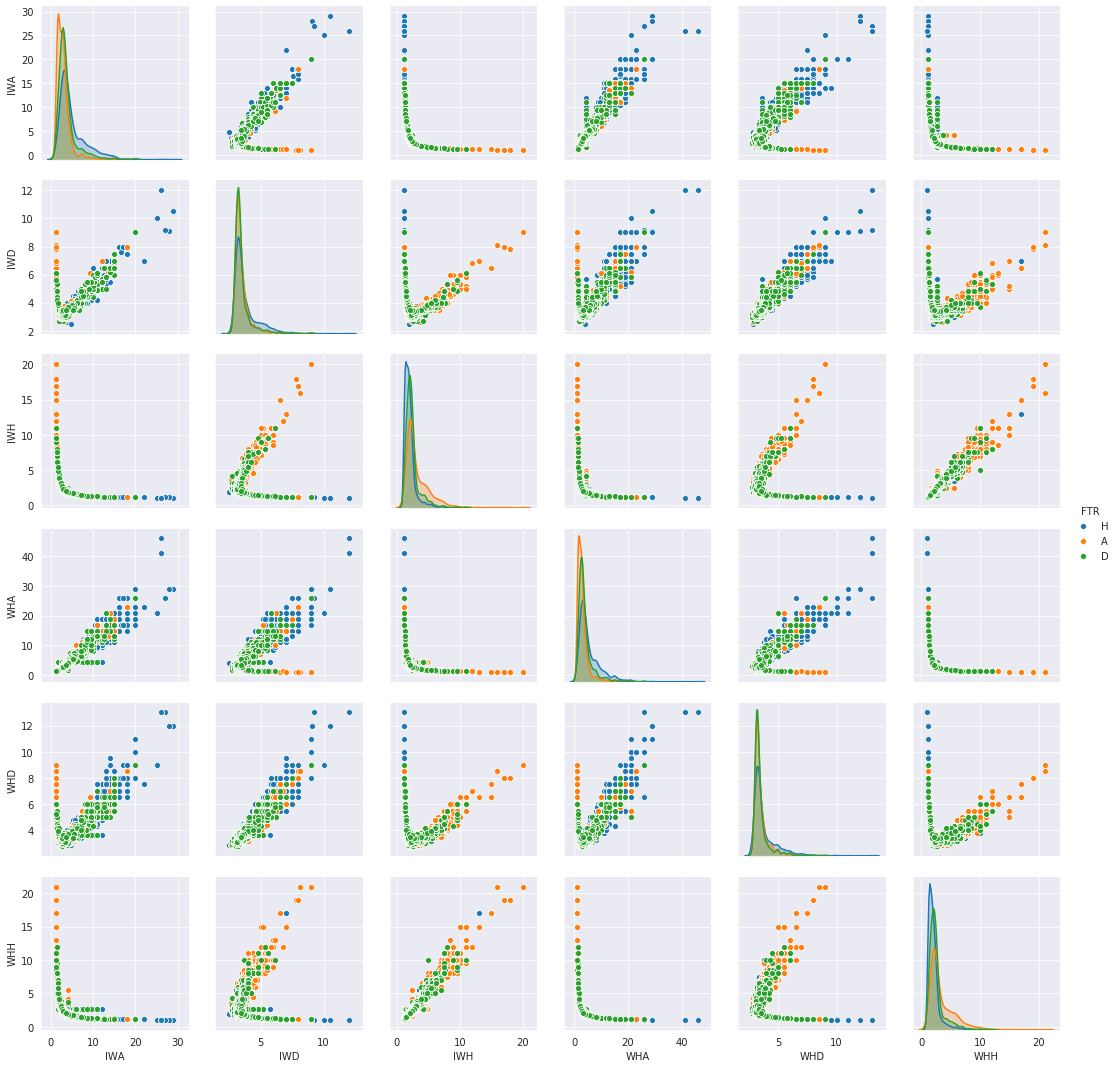

In [7]:
sns.set_style("darkgrid")
odds = ['IWA','IWD','IWH','WHA','WHD','WHH', 'FTR']
sns.pairplot(df[odds],hue='FTR')

<h3>We can see that most betting odds have a linear correlation when comparing outcome to outcome, dispersing a little more as the odds go up (which bookmakers tend to do to give the best price on an under dog).</h3>

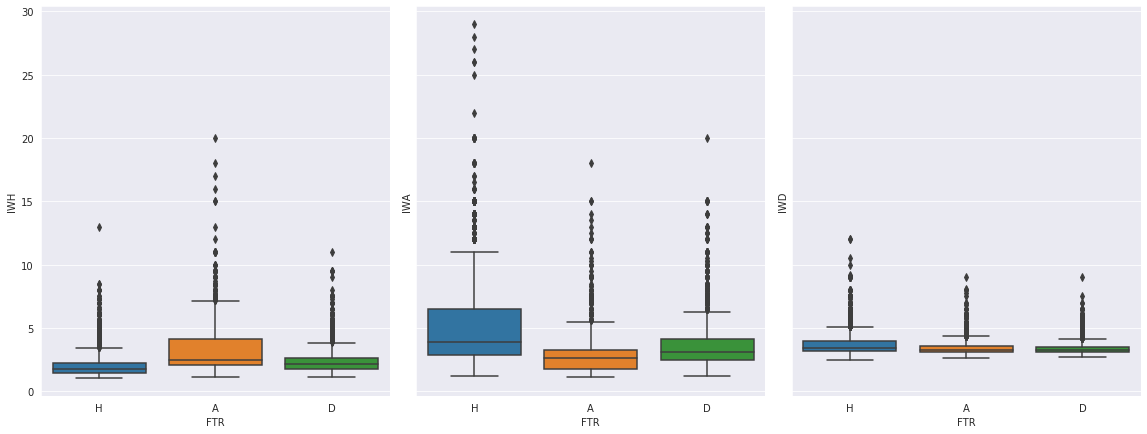

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16,6))
fig.tight_layout()
sns.catplot(y="IWH", x="FTR", kind="box", data=df, ax=ax1)
sns.catplot(y="IWA", x="FTR", kind="box", data=df, ax=ax2)
sns.catplot(y="IWD", x="FTR", kind="box", data=df, ax=ax3)
plt.close()
plt.close(2)
plt.close(3)
plt.show()

In [9]:
set(list(df['AwayTeam']) + list(df['HomeTeam']))

{'Arsenal',
 'Aston Villa',
 'Birmingham',
 'Blackburn',
 'Blackpool',
 'Bolton',
 'Bournemouth',
 'Bradford',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Charlton',
 'Chelsea',
 'Coventry',
 'Crystal Palace',
 'Derby',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Hull',
 'Ipswich',
 'Leeds',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man United',
 'Middlesboro',
 'Middlesbrough',
 'Newcastle',
 'Norwich',
 'Portsmouth',
 'QPR',
 'Reading',
 'Sheffield United',
 'Southampton',
 'Stoke',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wigan',
 'Wolves'}

<h3>Now let's do some feature engineering and try to extract some valuable insights from our data to help our model. To do this I'm going to focus these features around team performance metrics based on the simple information that we are given, mainly trying to identify patterns or trends in results that can be associated with form and help predict the teams performance in their next match.</h3>

In [10]:
# A simple binary feature to flag if a team won their previous match
won_last = defaultdict(int)

df["HomeLastWin"] = False
df["VisitorLastWin"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeLastWin"] = 1 if won_last[home_team] else 0
    row["VisitorLastWin"] = 1 if won_last[visitor_team] else 0
    df.loc[index] = row

    won_last[home_team] = row["FTR"] == 'H'
    won_last[visitor_team] = row["FTR"] == 'A'

In [11]:
#teams that lead at half time and lost last match, sign of fatigue?
half_lead_lost_last = defaultdict(int)

df["HmLasthlll"] = False
df["VisLasthlll"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HmLasthlll"] = 1 if half_lead_lost_last[home_team] else 0
    row["VisLasthlll"] = 1 if half_lead_lost_last[visitor_team] else 0
    df.loc[index] = row

    half_lead_lost_last[home_team] = row["HTR"] == 'H' and row["FTR"] == 'A'
    half_lead_lost_last[visitor_team] = row["HTR"] == 'A' and row["FTR"] == 'H'

In [12]:
#teams that were down and came back to win.
half_down_win_last = defaultdict(int)

df["Hmdwl"] = False
df["Visdwl"] = False

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["Hmdwl"] = 1 if half_down_win_last[home_team] else 0
    row["Visdwl"] = 1 if half_down_win_last[visitor_team] else 0
    df.loc[index] = row

    half_down_win_last[home_team] = row["HTR"] == 'A' and row["FTR"] == 'H'
    half_down_win_last[visitor_team] = row["HTR"] == 'H' and row["FTR"] == 'A'

In [13]:
# Team win streaks.
df["HomeWinStreak"] = 0
df["VisitorWinStreak"] = 0

win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinStreak"] = win_streak[home_team]
    row["VisitorWinStreak"] = win_streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1
    elif row["FTR"] == 'H':
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    elif row["FTR"] == 'D':
        win_streak[home_team] = 0
        win_streak[visitor_team] = 0

In [14]:
#Team unbeaten streaks (win or draw).
df["HomeUnbeatenStreak"] = 0
df["VisitorUnbeatenStreak"] = 0

streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeUnbeatenStreak"] = streak[home_team]
    row["VisitorUnbeatenStreak"] = streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'H':
        streak[home_team] += 1
        streak[visitor_team] = 0
    elif row["FTR"] == 'A':
        streak[home_team] = 0
        streak[visitor_team] += 1
    elif row["FTR"] == 'D':
        streak[home_team] += 1
        streak[visitor_team] += 1

In [15]:
# Team losing streaks
df["HomeLosingStreak"] = 0
df["VisitorLosingStreak"] = 0

losing_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeLosingStreak"] = losing_streak[home_team]
    row["VisitorLosingStreak"] = losing_streak[visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        losing_streak[home_team] += 1
        losing_streak[visitor_team] = 0
    elif row["FTR"] == 'H':
        losing_streak[home_team] = 0
        losing_streak[visitor_team] += 1
    elif row["FTR"] == 'D':
        losing_streak[home_team] = 0
        losing_streak[visitor_team] = 0

In [16]:
last_match_stats = {x:{"prev_S":0,
"prev_ST":0,
"prev_C":0} for x in set(list(df['AwayTeam']) + list(df['HomeTeam']))}
# HS = Home Team Shots
# AS = Away Team Shots
# HST = Home Team Shots on Target
# AST = Away Team Shots on Target
# HC = Home Team Corners
# AC = Away Team Corners
 
df["prev_HS"] = 0
df["prev_AS"] = 0
df["prev_HST"] = 0
df["prev_AST"] = 0
df["prev_HC"] = 0
df["prev_AC"] = 0

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    row["prev_HS"] = last_match_stats[home_team]["prev_S"] if last_match_stats[home_team]["prev_S"] else 0
    row["prev_HST"] = last_match_stats[home_team]["prev_ST"] if last_match_stats[home_team]["prev_ST"] else 0
    row["prev_HC"] = last_match_stats[home_team]["prev_C"] if last_match_stats[home_team]["prev_C"] else 0
    row["prev_AS"] = last_match_stats[away_team]["prev_S"] if last_match_stats[away_team]["prev_S"] else 0
    row["prev_AST"] = last_match_stats[away_team]["prev_ST"] if last_match_stats[away_team]["prev_ST"] else 0
    row["prev_AC"] = last_match_stats[away_team]["prev_C"] if last_match_stats[away_team]["prev_C"] else 0
    df.loc[index] = row

    last_match_stats[home_team]["prev_S"] = row["HS"]    
    last_match_stats[home_team]["prev_ST"] = row["HST"]    
    last_match_stats[home_team]["prev_C"] = row["HC"]
    last_match_stats[away_team]["prev_S"] = row["AS"]
    last_match_stats[away_team]["prev_ST"] = row["AST"]
    last_match_stats[away_team]["prev_C"] = row["AC"]

In [17]:
# at home win streak
df["AtHomeWinStreak"] = 0

ah_win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    row["AtHomeWinStreak"] = ah_win_streak[home_team]
    df.loc[index] = row

    if row["FTR"] == 'A' or row["FTR"] == 'D':
        ah_win_streak[home_team] = 0      
    elif row["FTR"] == 'H':
        ah_win_streak[home_team] += 1

In [18]:
# wins against visitor at home
df["HomeWinAgainstVisitor"] = 0

hwao = defaultdict(lambda: defaultdict(int))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinAgainstVisitor"] = hwao[home_team][visitor_team]
    df.loc[index] = row

    if row["FTR"] == 'A':
        hwao[home_team][visitor_team] = 0
    elif row["FTR"] == 'H':
        hwao[home_team][visitor_team] += 1

In [19]:
# wins against visitor streak
df["HomeWinAgainstVisitorStreak"] = 0
df["VisitorWinAgainstHomeStreak"] = 0

hwav = defaultdict(lambda: defaultdict(int))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinAgainstVisitorStreak"] = hwav[home_team][visitor_team]
    row["VisitorWinAgainstHomeStreak"] = hwav[visitor_team][home_team]
    df.loc[index] = row

    if row['FTR'] == 'A':
        hwav[visitor_team][home_team] += 1
        hwav[home_team][visitor_team] = 0
    elif row['FTR'] == 'H':
        hwav[home_team][visitor_team] += 1
        hwav[visitor_team][home_team] = 0

In [20]:
from collections import deque

class que(deque):
    def __init__(self, max_depth, **kwargs):
        super(deque, self).__init__(**kwargs)
        self.max_depth = max_depth
    
    def add(self, n):
        if self.__len__() == self.max_depth:
            self.popleft()
        self.append(n)
        
    @property    
    def wins_last_5(self):
        return 0 if not self.__len__() else sum(self)/self.__len__()

# teams last 5 win %
df["VisitorWPLast5"] = 0.0
df["HomeWPLast5"] = 0.0

l5 = defaultdict(lambda: que(max_depth=5))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["VisitorWPLast5"] = l5[visitor_team].wins_last_5
    row["HomeWPLast5"] = l5[home_team].wins_last_5
    df.loc[index] = row

    if row['FTR'] == 'A':
        l5[visitor_team].add(1)
        l5[home_team].add(0)
    elif row['FTR'] == 'H':
        l5[home_team].add(1)
        l5[visitor_team].add(0)

In [21]:
# visitor last 5 away games, home last 5 home games - win %
hl5 = defaultdict(lambda: que(max_depth=5))
al5 = defaultdict(lambda: que(max_depth=5))

df["VisitorWPALast5"] = 0.0
df["HomeWPHLast5"] = 0.0

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["VisitorWPALast5"] = al5[visitor_team].wins_last_5
    row["HomeWPHLast5"] = hl5[home_team].wins_last_5
    df.loc[index] = row

    if row['FTR'] == 'A':
        al5[visitor_team].add(1)
        hl5[home_team].add(0)
    elif row['FTR'] == 'H':
        hl5[home_team].add(1)
        al5[visitor_team].add(0)

In [22]:
# wins against visitor last 5 win%
df["HomeWinAgainstVisitorL5"] = 0.0
df["VisitorWinAgainstHomeL5"] = 0.0

hva5 = defaultdict(lambda: defaultdict(lambda: que(max_depth=5)))

for index, row in df.iterrows():
    home_team = row["HomeTeam"]
    visitor_team = row["AwayTeam"]
    row["HomeWinAgainstVisitorL5"] = hva5[home_team][visitor_team].wins_last_5
    row["VisitorWinAgainstHomeL5"] = hva5[visitor_team][home_team].wins_last_5
    df.loc[index] = row

    if row['FTR'] == 'A':
        hva5[visitor_team][home_team].add(1)
        hva5[home_team][visitor_team].add(0)
    elif row['FTR'] == 'H':
        hva5[home_team][visitor_team].add(1)
        hva5[visitor_team][home_team].add(0)

In [23]:
df.HomeUnbeatenStreak.value_counts()

0     3094
1     1378
2      896
3      563
4      370
5      243
6      174
7       97
8       81
9       61
10      48
11      41
12      27
14      23
13      21
16      17
19       9
15       8
20       7
18       7
17       7
21       7
26       4
24       4
22       3
29       3
25       3
23       3
39       2
30       2
27       2
31       2
28       2
32       1
47       1
36       1
48       1
33       1
37       1
45       1
34       1
42       1
35       1
41       1
Name: HomeUnbeatenStreak, dtype: int64

In [24]:
df.HomeLosingStreak.value_counts()

0     4145
1     1878
2      697
3      267
4      118
5       55
6       30
7       11
8        9
9        3
20       1
12       1
15       1
11       1
10       1
14       1
17       1
Name: HomeLosingStreak, dtype: int64

In [25]:
man_city = df[(df['HomeTeam'] == 'Man City') | (df['AwayTeam'] == 'Man City')]
man_city[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
          'HomeUnbeatenStreak','VisitorUnbeatenStreak', 'HomeLosingStreak','VisitorLosingStreak', 'AtHomeWinStreak',
          'HomeWinAgainstVisitor', 'HomeWinAgainstVisitorStreak', 'VisitorWinAgainstHomeStreak', 'VisitorWPLast5',
          'HomeWPLast5', 'VisitorWPALast5', 'HomeWPHLast5', 'HomeWinAgainstVisitorL5','VisitorWinAgainstHomeL5']]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeUnbeatenStreak,VisitorUnbeatenStreak,HomeLosingStreak,VisitorLosingStreak,AtHomeWinStreak,HomeWinAgainstVisitor,HomeWinAgainstVisitorStreak,VisitorWinAgainstHomeStreak,VisitorWPLast5,HomeWPLast5,VisitorWPALast5,HomeWPHLast5,HomeWinAgainstVisitorL5,VisitorWinAgainstHomeL5
0,19/08/00,Charlton,Man City,4.0,0.0,H,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,23/08/00,Man City,Sunderland,4.0,2.0,H,0,1,1,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,26/08/00,Man City,Coventry,1.0,2.0,A,1,1,0,0,1,0,0,0,0.500000,0.500000,1.000000,1.000000,0.000000,0.000000
29,05/09/00,Leeds,Man City,1.0,2.0,A,2,0,0,1,1,0,0,0,0.333333,1.000000,0.000000,1.000000,0.000000,0.000000
43,09/09/00,Liverpool,Man City,3.0,2.0,H,2,1,0,0,2,0,0,0,0.500000,0.666667,0.500000,1.000000,0.000000,0.000000
57,17/09/00,Man City,Middlesbrough,1.0,1.0,D,0,0,1,1,0,0,0,0,0.333333,0.400000,1.000000,0.500000,0.000000,0.000000
67,23/09/00,Tottenham,Man City,0.0,0.0,D,0,1,1,0,3,0,0,0,0.400000,0.600000,0.333333,1.000000,0.000000,0.000000
73,30/09/00,Man City,Newcastle,0.0,1.0,A,2,0,0,2,0,0,0,0,0.600000,0.400000,0.333333,0.500000,0.000000,0.000000
85,14/10/00,Man City,Bradford,2.0,0.0,H,0,1,1,0,0,0,0,0,0.200000,0.400000,0.000000,0.333333,0.000000,0.000000
98,23/10/00,Southampton,Man City,0.0,2.0,A,1,1,0,0,0,0,0,0,0.400000,0.400000,0.333333,0.333333,0.000000,0.000000


In [26]:
df.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'Date', 'Div', 'FTAG',
       'FTHG', 'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR',
       'HY', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'Referee', 'WHA', 'WHD', 'WHH',
       'HomeLastWin', 'VisitorLastWin', 'HmLasthlll', 'VisLasthlll', 'Hmdwl',
       'Visdwl', 'HomeWinStreak', 'VisitorWinStreak', 'HomeUnbeatenStreak',
       'VisitorUnbeatenStreak', 'HomeLosingStreak', 'VisitorLosingStreak',
       'prev_HS', 'prev_AS', 'prev_HST', 'prev_AST', 'prev_HC', 'prev_AC',
       'AtHomeWinStreak', 'HomeWinAgainstVisitor',
       'HomeWinAgainstVisitorStreak', 'VisitorWinAgainstHomeStreak',
       'VisitorWPLast5', 'HomeWPLast5', 'VisitorWPALast5', 'HomeWPHLast5',
       'HomeWinAgainstVisitorL5', 'VisitorWinAgainstHomeL5'],
      dtype='object')

In [27]:
#df.to_csv('2000_2019_data_complete.csv')

In [28]:
df = pd.get_dummies(df, columns=['HomeTeam', 'AwayTeam'])

In [29]:
df["target"] = [1 if x == 'H' else 0 for x in list(df["FTR"])]

In [30]:
X = df.drop(['Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HS', 'AS', 'HST', 
         'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',"Div", "Date", "FTHG",
         'FTAG','FTR','HTHG','HTAG','HTR'], axis=1).reset_index(drop=True)
X.columns

Index(['IWA', 'IWD', 'IWH', 'WHA', 'WHD', 'WHH', 'HomeLastWin',
       'VisitorLastWin', 'HmLasthlll', 'VisLasthlll',
       ...
       'AwayTeam_Stoke', 'AwayTeam_Sunderland', 'AwayTeam_Swansea',
       'AwayTeam_Tottenham', 'AwayTeam_Watford', 'AwayTeam_West Brom',
       'AwayTeam_West Ham', 'AwayTeam_Wigan', 'AwayTeam_Wolves', 'target'],
      dtype='object', length=123)

In [31]:
X.isnull().values.any()

False

In [32]:
X.columns

Index(['IWA', 'IWD', 'IWH', 'WHA', 'WHD', 'WHH', 'HomeLastWin',
       'VisitorLastWin', 'HmLasthlll', 'VisLasthlll',
       ...
       'AwayTeam_Stoke', 'AwayTeam_Sunderland', 'AwayTeam_Swansea',
       'AwayTeam_Tottenham', 'AwayTeam_Watford', 'AwayTeam_West Brom',
       'AwayTeam_West Ham', 'AwayTeam_Wigan', 'AwayTeam_Wolves', 'target'],
      dtype='object', length=123)

In [33]:
Y = X['target']
X = X[[x for x in X.columns if x != 'target']]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 5, stratify=Y, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5776, 122)
(1444, 122)
(5776,)
(1444,)


In [35]:
X_train.isnull().values.any()

False

/home/srooney/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train score: 0.668
Test score: 0.657
Test precision: 0.632
Test recall: 0.629
Test f1: 0.63


Text(91.68, 0.5, 'actual label')

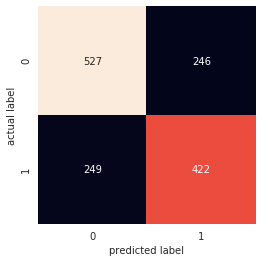

In [36]:
lr_clf = LogisticRegression(penalty='l1', C=0.24, class_weight='balanced')

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(f"Train score: {round(lr_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(lr_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, lr_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, lr_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, lr_y_pred), 3)}")

confmatrix = confusion_matrix(y_test, lr_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [37]:
eli5.show_weights(lr_clf, feature_names=list(X_train))

Weight?,Feature
+0.337,AwayTeam_QPR
+0.239,HomeTeam_Man United
+0.226,AwayTeam_Derby
+0.190,HomeTeam_Stoke
+0.183,HomeTeam_Newcastle
+0.168,HomeTeam_Arsenal
+0.151,HomeTeam_Tottenham
+0.148,HomeTeam_Everton
+0.138,HomeTeam_Fulham
+0.129,VisitorWPLast5


(0, 1)

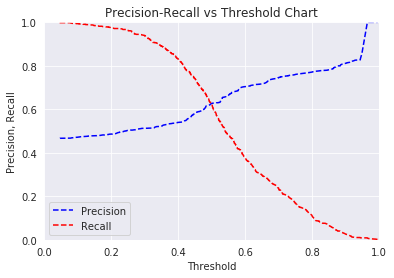

In [38]:
probs = [x[1] for x in lr_clf.predict_proba(X_test)]
precision, recall, thresholds = precision_recall_curve(y_test, probs) 
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, sorted(precision[: -1]), "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.xlim([0,1])

In [39]:
clf_rf = RandomForestClassifier(random_state=12, n_jobs=-1, class_weight='balanced')
param_dist = {'bootstrap': [True, False],
             'n_estimators': stats.randint(100, 2000),
             'criterion': ['gini', 'entropy'],
             'max_depth': stats.randint(1, 150),
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': stats.randint(1, 100),
             'min_samples_split': stats.randint(1, 100),
             'max_leaf_nodes': stats.randint(1, 100)
             }

rf_rndm = RandomizedSearchCV(clf_rf, param_distributions = param_dist,
                         cv = 5, random_state = 12, n_iter = 300,
                         scoring = 'roc_auc', error_score = 0,
                         verbose = 3, n_jobs = -1)

rf_rndm.fit(X_train, y_train)
print("Score: {}".format(rf_rndm.best_score_))
print(rf_rndm.best_estimator_)
print(rf_rndm.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 19.3min finished


Score: 0.7164195363650616
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=141, max_features='auto',
            max_leaf_nodes=53, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=22,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=182, n_jobs=-1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 141, 'max_features': 'auto', 'max_leaf_nodes': 53, 'min_samples_leaf': 22, 'min_samples_split': 6, 'n_estimators': 182}


Train score: 0.69
Test score: 0.653
Test precision: 0.63
Test recall: 0.613
Test f1: 0.621


Text(91.68, 0.5, 'actual label')

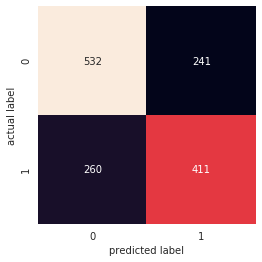

In [40]:
rf_clf = rf_rndm.best_estimator_
rf_clf.fit(X_train, y_train)

rf_y_pred = rf_clf.predict(X_test)

print(f"Train score: {round(rf_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(rf_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, rf_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, rf_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, rf_y_pred), 3)}")
      
rf_confmatrix = confusion_matrix(y_test, rf_y_pred)

sns.heatmap(rf_confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [41]:
eli5.show_weights(rf_clf, feature_names=list(X_train))

Weight,Feature
0.1692 ± 0.3835,IWA
0.1390 ± 0.3353,WHA
0.1328 ± 0.3313,IWH
0.1142 ± 0.3127,WHH
0.0532 ± 0.1342,WHD
0.0491 ± 0.1336,IWD
0.0246 ± 0.0850,HomeWPHLast5
0.0223 ± 0.0794,VisitorWinAgainstHomeL5
0.0211 ± 0.0664,VisitorWPALast5
0.0210 ± 0.0775,VisitorWPLast5


In [42]:
perm = PermutationImportance(rf_clf).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=[x for x in X.columns if x != 'target'])

Weight,Feature
0.0051 ± 0.0101,IWA
0.0041 ± 0.0020,HomeWPHLast5
0.0041 ± 0.0022,WHD
0.0040 ± 0.0017,prev_HS
0.0039 ± 0.0043,IWH
0.0037 ± 0.0027,IWD
0.0036 ± 0.0012,VisitorWinStreak
0.0034 ± 0.0089,WHA
0.0034 ± 0.0021,HomeWinAgainstVisitorL5
0.0032 ± 0.0024,VisitorLastWin


In [43]:
scorer = make_scorer(f1_score)

clf_xgb = XGBClassifier(objective = 'binary:logistic', n_jobs=-1, random_state=12)
param_dist = {'n_estimators': stats.randint(100, 2000),
              'booster': ['gbtree', 'dart'],
              'learning_rate': stats.uniform(0.0001, 0.1),
              'gamma':stats.uniform(0.001, 10),
              'subsample': stats.uniform(0.1, 0.9),
              'max_depth': stats.randint(1, 150),
              'max_bin': stats.randint(4, 1000),
              'colsample_bytree': stats.uniform(0.1, 0.9),
              'min_child_weight': stats.randint(1, 100),
              'reg_alpha': stats.randint(2, 150),
              'reg_lambda': stats.randint(2, 150)
             }

xg_rndm = RandomizedSearchCV(clf_xgb, param_distributions = param_dist,
                         cv = 5, random_state = 12, n_iter = 50,
                         scoring = scorer, verbose = 3, n_jobs = -1)

xg_rndm.fit(X_train, y_train)
print("Score: {}".format(xg_rndm.best_score_))
print(xg_rndm.best_estimator_)
print(xg_rndm.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.9min finished


Score: 0.623205229661752
XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=0.9360248455169348, gamma=0.20672352213584888,
       learning_rate=0.09371517985575505, max_bin=536, max_delta_step=0,
       max_depth=106, min_child_weight=70, missing=None, n_estimators=279,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=45, reg_lambda=45, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.1251170099753793)
{'booster': 'dart', 'colsample_bytree': 0.9360248455169348, 'gamma': 0.20672352213584888, 'learning_rate': 0.09371517985575505, 'max_bin': 536, 'max_depth': 106, 'min_child_weight': 70, 'n_estimators': 279, 'reg_alpha': 45, 'reg_lambda': 45, 'subsample': 0.1251170099753793}


Train score: 0.663
Test score: 0.663
Test precision: 0.651
Test recall: 0.59
Test f1: 0.619


Text(91.68, 0.5, 'actual label')

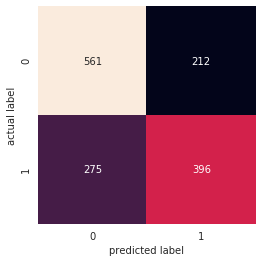

In [44]:
xg_clf = xg_rndm.best_estimator_

xg_clf.fit(X_train, y_train)

xg_y_pred = xg_clf.predict(X_test)

print(f"Train score: {round(xg_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(xg_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, xg_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, xg_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, xg_y_pred), 3)}")

confmatrix = confusion_matrix(y_test, xg_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [45]:
from eli5.xgboost import explain_weights_xgboost
explain_weights_xgboost(xg_clf)

ValueError: Feature importance is not defined for Booster type dart

In [46]:
scorer = make_scorer(f1_score)

params ={'n_estimators': stats.randint(1, 5000),
         'learning_rate': [0.005, 0.01, 0.1, 1],
         'num_iterations': stats.randint(1, 5000),
             'boosting_type':['gbdt', 'dart'],
             'max_depth': stats.randint(-1, 150),
             'max_bin': stats.randint(4, 500),
             'num_leaves': stats.randint(3, 200), 
             'min_child_samples': stats.randint(1, 500),
             'min_child_weight': stats.randint(0, 50),
             'subsample': stats.uniform(loc=0.2, scale=0.8),
             'colsample_bytree' : [0.65, 0.66, 0.8, 0.9],
             'reg_alpha': stats.randint(2, 200),
             'reg_lambda': stats.randint(2, 200)
            }

clf_lgbm = lgbm.LGBMClassifier(random_state=12, objective='binary',silent=True, 
                          metric='binary_error', n_jobs=-1)

lgbm_rndm = RandomizedSearchCV(clf_lgbm, param_distributions=params, 
                            n_iter=50, scoring=scorer, cv=5,
                            refit=True, random_state=12,verbose=1,n_jobs=-1)

lgbm_rndm.fit(X_train, y_train)
print("Score: {}".format(lgbm_rndm.best_score_))
print(lgbm_rndm.best_estimator_)
print(lgbm_rndm.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.7min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Score: 0.606414337992414
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.1, max_bin=182,
        max_depth=16, metric='binary_error', min_child_samples=149,
        min_child_weight=42, min_split_gain=0.0, n_estimators=360,
        n_jobs=-1, num_iterations=2856, num_leaves=161, objective='binary',
        random_state=12, reg_alpha=19, reg_lambda=72, silent=True,
        subsample=0.5274657142794588, subsample_for_bin=200000,
        subsample_freq=0)
{'boosting_type': 'gbdt', 'colsample_bytree': 0.66, 'learning_rate': 0.1, 'max_bin': 182, 'max_depth': 16, 'min_child_samples': 149, 'min_child_weight': 42, 'n_estimators': 360, 'num_iterations': 2856, 'num_leaves': 161, 'reg_alpha': 19, 'reg_lambda': 72, 'subsample': 0.5274657142794588}


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train score: 0.672
Test score: 0.661
Test precision: 0.65
Test recall: 0.586
Test f1: 0.616


Text(91.68, 0.5, 'actual label')

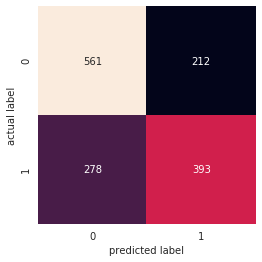

In [47]:
lgbm_clf = lgbm_rndm.best_estimator_

lgbm_clf.fit(X_train, y_train)

lgbm_y_pred = lgbm_clf.predict(X_test)

print(f"Train score: {round(lgbm_clf.score(X_train, y_train), 3)}")
print(f"Test score: {round(lgbm_clf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, lgbm_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, lgbm_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, lgbm_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, lgbm_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [48]:
from eli5.lightgbm import explain_weights_lightgbm
explain_weights_lightgbm(lgbm_clf)

Weight,Feature
0.4107,IWA
0.3494,WHA
0.1287,IWH
0.0270,WHH
0.0141,prev_HS
0.0120,IWD
0.0086,HomeWPHLast5
0.0085,prev_AS
0.0075,prev_AST
0.0054,WHD


Train score: 0.671
Test score: 0.662
Test precision: 0.652
Test recall: 0.586
Test f1: 0.617


Text(91.68, 0.5, 'actual label')

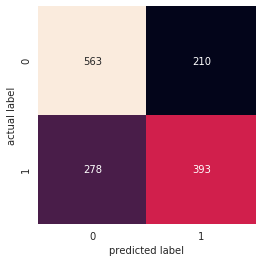

In [65]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('lg', lgbm_clf), ('xg', xg_clf), ('rf', rf_clf), ('lr', lr_clf)],
                         voting='hard', n_jobs=-1)

eclf = eclf.fit(X_train, y_train)

e_y_pred = eclf.predict(X_test)

print(f"Train score: {round(eclf.score(X_train, y_train), 3)}")
print(f"Test score: {round(eclf.score(X_test, y_test), 3)}")
print(f"Test precision: {round(precision_score(y_test, e_y_pred), 3)}")
print(f"Test recall: {round(recall_score(y_test, e_y_pred), 3)}")
print(f"Test f1: {round(f1_score(y_test, e_y_pred), 3)}")

%matplotlib inline

confmatrix = confusion_matrix(y_test, e_y_pred)

sns.heatmap(confmatrix, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('predicted label')
plt.ylabel('actual label')

In [66]:
xpbs = X.copy()

In [67]:
def undummy(d):
    return d.dot(d.columns)

xpbs = xpbs.assign(HomeTeam=xpbs.filter(regex='^HomeTeam').pipe(undummy))
xpbs = xpbs.assign(AwayTeam=xpbs.filter(regex='^AwayTeam').pipe(undummy))

In [68]:
rf_probs = rf_clf.predict_proba(X)
rf_probs = [x[1] for x in rf_probs]
xgprobs = xg_clf.predict_proba(X)
xgprobs = [x[1] for x in xgprobs]
lgbmprobs = lgbm_clf.predict_proba(X)
lgbmprobs = [x[1] for x in lgbmprobs]
lrprobs = lr_clf.predict_proba(X)
lrprobs = [x[1] for x in lrprobs]
epreds = eclf.predict(X)
xpbs["xg_probs"] = xgprobs
xpbs["rf_probs"] = rf_probs
xpbs["lgbm_probs"] = lgbmprobs
xpbs["lr_probs"] = lrprobs
xpbs["ens_preds"] = epreds
xpbs["actual"] = y_test
xpbs[[x for x in list(xpbs) if 'pc_' not in x]]

,IWA,IWD,IWH,WHA,WHD,WHH,HomeLastWin,VisitorLastWin,HmLasthlll,VisLasthlll,Hmdwl,Visdwl,HomeWinStreak,VisitorWinStreak,HomeUnbeatenStreak,VisitorUnbeatenStreak,HomeLosingStreak,VisitorLosingStreak,prev_HS,prev_AS,prev_HST,prev_AST,prev_HC,prev_AC,AtHomeWinStreak,HomeWinAgainstVisitor,HomeWinAgainstVisitorStreak,VisitorWinAgainstHomeStreak,VisitorWPLast5,HomeWPLast5,VisitorWPALast5,HomeWPHLast5,HomeWinAgainstVisitorL5,VisitorWinAgainstHomeL5,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesboro,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesboro,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,HomeTeam,AwayTeam,xg_probs,rf_probs,lgbm_probs,lr_probs,ens_preds,actual
0,2.70,2.90,2.20,3.10,3.20,2.10,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Charlton,AwayTeam_Man City,0.413222,0.436428,0.439386,0.449121,0,NaN
1,4.20,3.20,1.60,6.50,3.60,1.44,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,HomeTeam_Chelsea,AwayTeam_West Ham,0.555951,0.653268,0.624112,0.581905,1,NaN
2,2.70,2.90,2.20,2.62,3.20,2.30,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Coventry,AwayTeam_Middlesbrough,0.387015,0.415178,0.418520,0.440043,0,NaN
3,3.50,3.00,1.80,3.20,3.20,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,HomeTeam_Derby,AwayTeam_Southampton,0.466252,0.474127,0.466129,0.496584,0,NaN
4,4.50,3.30,1.55,4.50,3.50,1.61,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Leeds,AwayTeam_Everton,0.555951,

In [69]:
xpbs.loc[(xpbs['ens_preds'] == 1) & (xpbs['actual'] == 0)]

,IWA,IWD,IWH,WHA,WHD,WHH,HomeLastWin,VisitorLastWin,HmLasthlll,VisLasthlll,Hmdwl,Visdwl,HomeWinStreak,VisitorWinStreak,HomeUnbeatenStreak,VisitorUnbeatenStreak,HomeLosingStreak,VisitorLosingStreak,prev_HS,prev_AS,prev_HST,prev_AST,prev_HC,prev_AC,AtHomeWinStreak,HomeWinAgainstVisitor,HomeWinAgainstVisitorStreak,VisitorWinAgainstHomeStreak,VisitorWPLast5,HomeWPLast5,VisitorWPALast5,HomeWPHLast5,HomeWinAgainstVisitorL5,VisitorWinAgainstHomeL5,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesboro,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesboro,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,HomeTeam,AwayTeam,xg_probs,rf_probs,lgbm_probs,lr_probs,ens_preds,actual
17,3.20,2.90,1.90,4.33,3.25,1.70,0,0,0,0,0,0,0,0,1,0,0,1,13.0,6.0,6.0,3.0,8.0,8.0,0,0,0,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Southampton,AwayTeam_Coventry,0.500130,0.527730,0.557485,0.541569,1,0.0
29,5.50,3.60,1.40,7.00,3.75,1.40,1,0,0,0,0,0,2,0,2,0,0,1,16.0,14.0,11.0,5.0,8.0,5.0,1,0,0,0,0.333333,1.0,0.000000,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Leeds,AwayTeam_Man City,0.555951,0.696191,0.681887,0.665107,1,0.0
47,3.50,3.00,1.80,3.20,3.20,2.00,0,0,0,0,0,0,0,0,2,1,0,0,9.0,8.0,5.0,6.0,11.0,10.0,0,0,0,0,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Derby,AwayTeam_Charlton,0.466252,0.511128,0.502862,0.561458,1,0.0
64,4.20,3.20,1.60,4.50,3.50,1.61,1,0,0,0,0,0,3,0,6,0,0,1,17.0,16.0,9.0,10.0,5.0,15.0,3,0,0,0,0.333333,1.0,0.000000,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,HomeTeam_Man United,AwayTeam_Chelsea,0.555951,0.628611,0.627262,0.660899,1,0.0
70,3.50,3.00,1.80,3.75,3.30,1.80,1,0,0,0,0,0,2,0,4,0,0,2,4.0,9.0,2.0,2.0,7.0,5.0,1,0,0,0,0.400000,0.6,0.666667,1.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [70]:
xpbs[['HomeTeam', 'lr_probs', 'xg_probs', 'rf_probs', 'lgbm_probs']].groupby('HomeTeam').describe()

lr_probs                                          \
                             count      mean       std       min       25%   
HomeTeam                                                                     
HomeTeam_Arsenal             361.0  0.699606  0.143602  0.249303  0.601376   
HomeTeam_Aston Villa         304.0  0.409105  0.129980  0.079264  0.339531   
HomeTeam_Birmingham          133.0  0.410158  0.116849  0.115087  0.324552   
HomeTeam_Blackburn           209.0  0.437687  0.128729  0.077194  0.371324   
HomeTeam_Blackpool            19.0  0.346594  0.139683  0.081596  0.263719   
HomeTeam_Bolton              209.0  0.423957  0.129958  0.076020  0.353273   
HomeTeam_Bournemouth          76.0  0.406588  0.146622  0.019396  0.330779   
HomeTeam_Bradford             19.0  0.375107  0.093881  0.156304  0.323009   
HomeTeam_Brighton             38.0  0.340247  0.156796  0.002380  0.223881   
HomeTeam_Burnley              95.0  0.328116  0.152173  0.003355  0.201742   
HomeTeam_Cardiff              38.0  0.318528  0.150476  0.004441  0.169346   
HomeTeam_Charlton            133.0  0.418115  0.109239  0.101665  0.364337   
HomeTeam_Chelsea             361.0  0.693537  0.152984  0.277233  0.581554   
HomeTeam_Coventry             19.0  0.430377  0.087010  0.227832  0.393783   
HomeTeam_Crystal Palace      133.0  0.392289  0.161521  0.033283  0.275510   
HomeTeam_Derby                57.0  0.370193  0.134073  0.017788  0.300520   
HomeTeam_Everton             361.0  0.520657  0.140173  0.044513  0.431670   
HomeTeam_Fulham              266.0  0.445449  0.139056  0.000970  0.388953   
HomeTeam_Huddersfield         38.0  0.291489  0.159209  0.001833  0.176796   
HomeTeam_Hull                 95.0  0.363698  0.141804  0.037582  0.270152   
HomeTeam_Ipswich              38.0  0.451519  0.120236  0.193610  0.381879   
HomeTeam_Leeds                76.0  0.485764  0.127878  0.173255  0.382970   
HomeTeam_Leicester           152.0  0.433891  0.141094  0.068692  0.356446   
HomeTeam_Liverpool           361.0  0.647742  0.155175  0.223788  0.529263   
HomeTeam_Man City            342.0  0.630370  0.199309  0.141614  0.485484   
HomeTeam_Man United          361.0  0.737053  0.147891  0.140138  0.646148   
HomeTeam_Middlesboro          19.0  0.479727  0.103437  0.287524  0.411898   
HomeTeam_Middlesbrough       171.0  0.428314  0.128545  0.038199  0.378009   
HomeTeam_Newcastle           323.0  0.493289  0.143049  0.020914  0.419731   
HomeTeam_Norwich              95.0  0.376865  0.135760  0.074114  0.286374   
HomeTeam_Portsmouth          133.0  0.412185  0.136936  0.053725  0.340340   
HomeTeam_QPR                  57.0  0.365161  0.149044  0.068939  0.247271   
HomeTeam_Reading              57.0  0.390834  0.151818  0.072793  0.310110   
HomeTeam_Sheffield United     19.0  0.378554  0.149430  0.057365  0.392865   
HomeTeam_Southampton         228.0  0.429407  0.134052  0.078003  0.342581   
HomeTeam_Stoke               190.0  0.434662  0.147503  0.030965  0.341469   
HomeTeam_Sunderland          266.0  0.354111  0.130520  0.024691  0.269070   
HomeTeam_Swansea             133.0  0.405100  0.153915  0.026469  0.312334   
HomeTeam_Tottenham           361.0  0.595094  0.148807  0.226265  0.489517   
HomeTeam_Watford              95.0  0.380118  0.147823  0.022081  0.286623   
HomeTeam_West Brom           228.0  0.384070  0.135410  0.027702  0.307897   
HomeTeam_West Ham            304.0  0.427522  0.140431  0.038923  0.350888   
HomeTeam_Wigan               152.0  0.386356  0.143028  0.022380  0.299705   
HomeTeam_Wolves               95.0  0.393295  0.159655  0.022336  0.280500   

                                                        xg_probs            \
                                50%       75%       max    count      mean   
HomeTeam                                                                     
HomeTeam_Arsenal           0.723614  0.804910  0.974305    361.0  0.530660   
HomeTeam_Aston Villa       0.413798  0.493642  

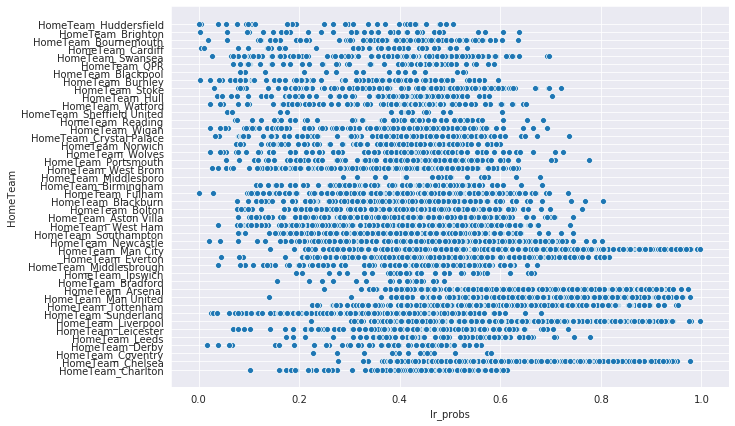

In [64]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(x="lr_probs", y="HomeTeam", data=xpbs)

### Our model has identified the big 6

In [58]:
pd.set_option('display.max_columns', 500)
df.loc[df.HomeWinStreak == max(df.HomeWinStreak)]

,AC,AF,AR,AS,AST,AY,Date,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,IWA,IWD,IWH,Referee,WHA,WHD,WHH,HomeLastWin,VisitorLastWin,HmLasthlll,VisLasthlll,Hmdwl,Visdwl,HomeWinStreak,VisitorWinStreak,HomeUnbeatenStreak,VisitorUnbeatenStreak,HomeLosingStreak,VisitorLosingStreak,prev_HS,prev_AS,prev_HST,prev_AST,prev_HC,prev_AC,AtHomeWinStreak,HomeWinAgainstVisitor,HomeWinAgainstVisitorStreak,VisitorWinAgainstHomeStreak,VisitorWPLast5,HomeWPLast5,VisitorWPALast5,HomeWPHLast5,HomeWinAgainstVisitorL5,VisitorWinAgainstHomeL5,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesboro,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Sheffield United,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Bradford,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Charlton,AwayTeam_Chelsea,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesboro,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,target
6645,6.0,7.0,0.0,5.0,1.0,1.0,23/12/2017,E0,0.0,4.0,H,4.0,8.0,0.0,14.0,5.0,0.0,1.0,H,0.0,20.0,9.0,1.12,M Jones,26.0,11.0,1.1,1,0,0,0,0,0,16,0,26,0,0,2,20.0,6.0,11.0,2.0,5.0,2.0,8,2,5,0,0.4,1.0,0.4,1.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
